### Example 4: Computing layer optical properties and writing a simple forward model
Part of ESE 156 Remote Sensing Class;
Christian Frankenberg
__________
So far, we have learned about the basics of optical properties of trace gases and their dependence on pressure and temperature in particular (both in terms of the line-shapes but also redistribution of line-strengths within a band due to the Boltzmann distribution of the population of rotational states).

The purpose of this exercise is to compute optical properties of a vertically structured atmosphere (varying in pressure, temperature and of course mixing ratios). We will first look at idealized examples, for which we assume a direct light-path between the sun and an observer on the ground (e.g. a TCCON measurement taken right in the Linde Robinson building!).

You will also learn a little about accessing Numerical Weather Forecast models, see e.g. for accessing grib data:
http://nbviewer.jupyter.org/gist/jswhit/8635665

In [1]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
figsize(10,8)

### Layer properties

If the cross sections vary substantially as a function of pressure and temperature (as they do for rotational/vibrational transitions), we need to divide the atmosphere into separate layers to compute optical properties for each of those, assuming a specific p and T for this layer. 

What we also need is the vertical column density (VCD) of each layer separately. The total VCD of a gas $i$ with volume mixing ratio in dry air $VMR_i$ is given as 
$$VCD = \int_{z_s}^\infty VMR(z) \cdot \rho_{N,dryAir}(z) dz\,,$$
where we use the number density $\rho_{N}$ (e.g. in molec/cm$^3$).

This quantity depends on both surface pressure as well as the actual $VMR$. For well-mixed gases, where changes in surface pressure outweigh the impact of changes in $VMR$, we often use the column-averaged mixing ration $X_i$:
$$X_{Gas} = \frac{VCD_{Gas}}{\int_{z_s}^\infty \rho_{N,dryAir}(z) dz}$$



To compute layer properties, we just integrate from one pressure level to the next:

$$VCD_i = \int_{z_i}^{z_{i+1}} VMR(z) \cdot \rho_{N,dryAir}(z) dz \approx VMR_i \cdot \rho_{N,dryAir}\cdot \Delta z\,,$$

where we should use layer averages for both $\rho_{N,dryAir}$ as well as $VMR$.

Most atmospheric profiles don't really provide actual height but are only given in pressure coordinates, typically as a function of surface pressure. So we will need to compute $\Delta z$ ourself from atmospheric profile data. 

For this, we can use the hypsometric equation (see https://en.wikipedia.org/wiki/Hypsometric_equation), which relates an atmospheric pressure ratio to the equivalent thickness of an atmospheric layer under the assumptions of constant temperature and gravity (which works for the thin layers we want):

$$\Delta z = z_2-z_1 = \frac{R_dT_v}{g}\cdot\ln{\frac{p_1}{p_2}}\,$$
with $R_d$ being the specific gas constant for dry air and $T_v$ the virtual temperature. 

All we need to compute $\Delta z$ given the pressure values at the bottom and top of an atmospheric layer is thus the average virtual temperature of the respective layer as well as the gravity constant at the specific location and height. 

The virtual temperature (see, e.g. https://en.wikipedia.org/wiki/Virtual_temperature, http://kiwi.atmos.colostate.edu/group/dave/at745/Virtual_Temp.pdf) is a construct to use a constant specific gas constant for air without adjusting for the changes in mean molar mass (which is dominated by changes in H$_2$O as its molar mass is much smaller than N$_2$ and O$_2$).

$T_v$ can be easily approximated using the specific humidity $q$:
$$T_v = T\cdot(1+0.608q)$$
(See derivation in the link to CSU above, we basically make use the of ratio of the specific gas constants for dry air and water vapor independently, with the ratio $R_d/R_v\approx 0.622$).

Now we just need to approximate $g$, which we can either assume as constant or really compute as function of latitude $\phi$ (geoid instead of perfect sphere) as well as height.

$$g(\phi,0m) \approx 9.780327 m/s^2 \cdot(1+0.0053024 \sin^2 \phi - 0.0000058 \sin^2 2\phi)$$

This equation is the International Gravity Formula 1967 (see https://en.wikipedia.org/wiki/Gravity_of_Earth#Latitude_model). 

The gravity at the equator is 9.780327$\,$m/s$^2$ and at the poles 9.83218620588$\,$m/s$^2$, a change of about 0.5%. This is small but non-negigible if you want to get column averaged trace gas concentrations to better than 1ppm for CO$_2$, which is only 0.25% of the background of 400ppm!

The last part if gravity dependence on height as the current values is given for the sea level equivalent.

In general, gravity from a body of mass $m$ (here using Earth, with $m_{earth}=5.9722\cdot 10^{24}kg$ is
$$g_o=\frac{G m_{Earth}}{r^2_{Earth}}\,$$
with G being the gravitational constant and $r_{Earth}$ the reference Earth radius of 6.371$\cdot 10^6$m.

The ratio of the gravity at sea level and at height h is thus
$$g_h/g_0 = \frac{r_{earth}^2}{(r_{earth}+h)^2}$$

We can thus define 
$$g(\phi,h) = g(\phi,0m)\cdot \frac{r_{earth}^2}{(r_{earth}+h)^2}$$
##### Few more constants
gas constant $R_d$ in J/kg/K for dry air: 
R_d = 287.04;

universal gas constant: 
R_universal = 8.314472;

Avogadro number: 
Na = 6.0221415e23;

_____


### Actually calculating the layer sub-column densities based on atmospheric profile data

Now that we have learned the basics of how to compute layer properties, we need to apply that knowledge using some real atmospheric data. For the lack of a better example (a lot of other real-time data is in a funny GRIB format), I chose some data from the openDAP server from NOAA, available as netCDF4 datasets. In this last example here, I actually pre-downloaded data from the MERRA re-analysis (large file!).

In [2]:
import netCDF4
from mpl_toolkits.basemap import Basemap
#from urllib.request import urlopen

In [3]:
mydate='20181007'
startTime = '18z' # There is 00, 06, 12 and 18 in UTC, i.e. 6 hourly data stacked together

# What latitude do we want? Take Caltech as example
myLat = 34.1377
myLon = 118.1253

# Try to access numerical weather forecast data (GFS here, using openDAP datasets)
#url = 'http://nomads.ncep.noaa.gov:9090/dods/gfs_0p25/gfs' + mydate + '/gfs_0p25_'+startTime
#url = 'https://goldsmr3.sci.gsfc.nasa.gov:443/opendap/MERRA/MAI6NVANA.5.2.0/2015/06/MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf'

# decided to download on my own (large!)
# Dowload file here: ftp://fluo.gps.caltech.edu/XYZT_ESE156/Data/MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4
url = 'files/MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4'

In [4]:
file = netCDF4.Dataset(url)

lat  = file.variables['YDim'][:]
lon  = file.variables['XDim'][:]
# Temperature profile
T =    file.variables['T'][:]
# specific humidity profile
q =    file.variables['QV'][:]
# mean pressure profile:
p = file.variables['Height'][:]
# Surafce pressure
psurf = file.variables['PS'][:]
# Time in UTC
time = file.variables['TIME'][:]

# AK and BK global attributes (important to calculate pressure half-levels)
ak = file.getncattr('HDF_GLOBAL.ak')[:]
bk = file.getncattr('HDF_GLOBAL.bk')[:]

file.close()
print(T.shape)

(4, 72, 361, 540)


_____
Somewhat off-topic but now that we have read global data, I just wanted to show you how you can display them on the globe using python matplotlib and basemap. See below:
_____

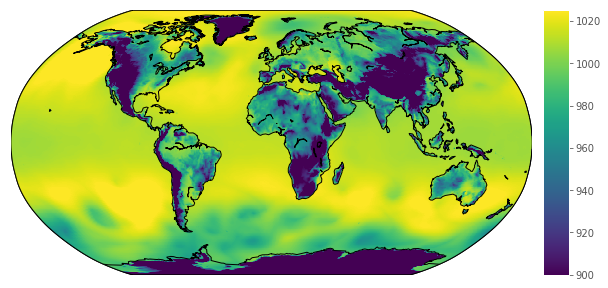

In [6]:
figsize(10,8)
# Plot one example on the globe (surface pressure in hPa)
m=Basemap(projection='robin',lon_0=0, resolution='c')

# convert the lat/lon values to x/y projections.
x, y = m(*np.meshgrid(lon,lat))

# plot the field using the fast pcolormesh routine 
# set the colormap to jet.
m.pcolormesh(x,y,psurf[1,:,:]/100.,shading='flat',cmap=plt.cm.viridis, vmin=900, vmax=1025)
m.colorbar(location='right')

# Add a coastline and axis values.
m.drawcoastlines()
m.drawmapboundary()

In [7]:
# Find the indices in lat/lon that best match Caltech here:
iLat = np.argmin(np.abs(lat-myLat))
iLon = np.argmin(np.abs(lon-myLon))

print(iLat, iLon)
print(psurf[:,iLat,iLon]/100.)

248 447
[998.7938842773438 997.3343505859375 1000.31982421875 1002.7118530273438]


Text(0.5, 1.0, 'Atmospheric Temperature profile at Caltech (6-hourly data on 20150613)')

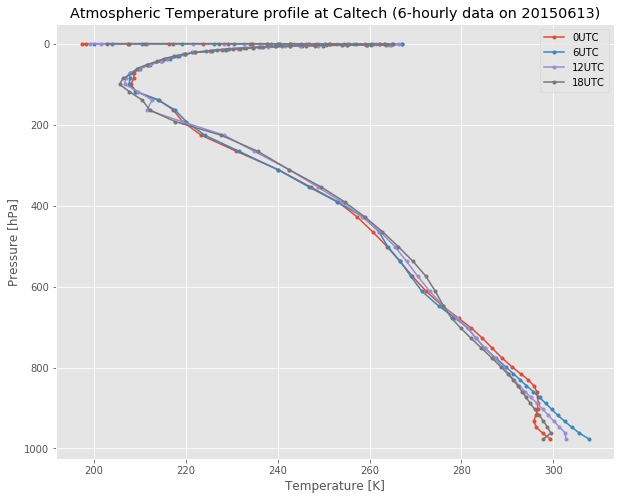

In [8]:
for i in range(4):
    plt.plot(T[i,:,iLat,iLon],p, '.-', label=str(i*6)+'UTC')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [hPa]')
plt.title('Atmospheric Temperature profile at Caltech (6-hourly data on 20150613)')

Text(0.5, 1.0, 'Atmospheric Temperature profile at Caltech (6-hourly data on 20150613)')

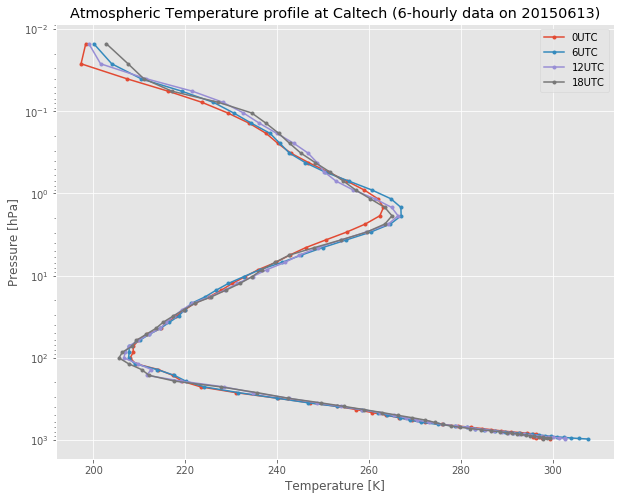

In [9]:
for i in range(4):
    plt.semilogy(T[i,:,iLat,iLon],p, '.-', label=str(i*6)+'UTC')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [hPa]')
plt.title('Atmospheric Temperature profile at Caltech (6-hourly data on 20150613)')

Here, the y-axis is logarithmic. What does this roughly represent in a linear way?

Can you identify the Tropopause, Stratosphere, Stratopause? 

What is the tropopause height?

Text(0.5, 1.0, 'Specific humidity profile at Caltech (6-hourly data on 20150613)')

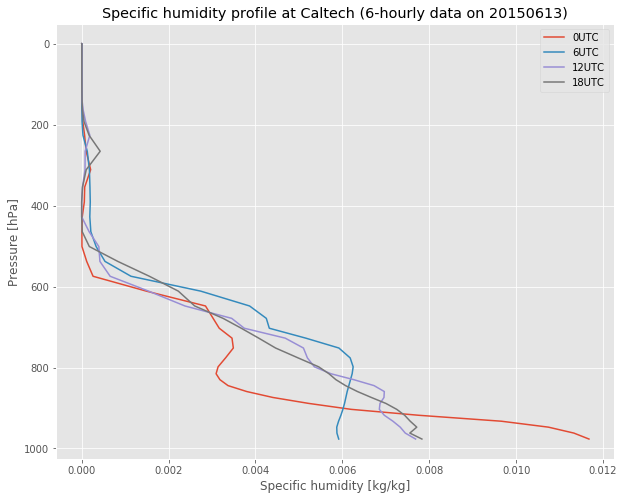

In [10]:
for i in range(4):
    plt.plot(q[i,:,iLat,iLon],p, label=str(i*6)+'UTC')
    
plt.legend(loc=0)
plt.gca().invert_yaxis()
plt.xlabel('Specific humidity [kg/kg]')
plt.ylabel('Pressure [hPa]')
plt.title('Specific humidity profile at Caltech (6-hourly data on 20150613)')

#### Computing the vertical sub-columns now per layer:
One tricky part in numerical weather forecast data is how levels are defined, see Section 2.2 in http://www.ecmwf.int/sites/default/files/elibrary/2015/9210-part-iii-dynamics-and-numerical-procedures.pdf

Usually, variables are defined in $NLEV$ layers, with pressures at the so-called half-levels defined at the boundaries between the layers, providing $NLEV+1$ half-levels:
$$p_{k+1/2} = A_{k+1/2} + B_{k+1/2}p_{surf}$$




In [11]:
# Let's choose one index in the time-domain
index = 1

# Surface pressure at Caltech and time slice 1 (scalar):
ps_local = psurf[index,iLat,iLon]
# q and T profiles at Caltech and time slice 1 (vector):
q_local = q[index,:,iLat,iLon]
T_local = T[index,:,iLat,iLon]

# Half-level (at the boundaries, one index more), 
# factor 100 is for conversion between Pa and hPa
p_half = (ak + bk*ps_local)/100.
# Full-levels, layer centered values:
p_full = (p_half[0:-1]+p_half[1:])/2.
NLEV = len(p_full)

# Let us ignore gravity changes for simplicity
go = 9.8196 #(m/s**2) 
Rd = 287.04 # specific gas constant for dry air
R_universal = 8.314472;
Na = 6.0221415e23;
    
# array for dz
dz = np.zeros((NLEV,))
# array for molar density of dry air for each layer:
rho_N = np.zeros((NLEV,))
rho_N_h2o = np.zeros((NLEV,))
# also get a VMR vector of H2O (volumetric!)
vmr_h2o = np.zeros((NLEV,))
# Now actually compute the layer thickness in meters
for i in range(NLEV):
    # Compute $\Delta$-z:
    dz[i]    =  np.log(p_half[i+1]/p_half[i])*Rd*T_local[i]*(1+0.608*q_local[i])/go
    # provide dry air density in molec/cm2/m (by diving molec/m3 by (100*100))
    # For dry air, we actually have to subtract water vapor from the volumetric mixing ratio, i.e. (1-VMR_{volume}(H2O))
    rho_N[i] =  p_full[i]*(1-q_local[i]*1.6068)*100./(R_universal*T_local[i])*Na/10000.0
    # Do the equivalent for the water vapor contribution
    rho_N_h2o[i] =  p_full[i]*(q_local[i]*1.6068)*100./(R_universal*T_local[i])*Na/10000.0
    vmr_h2o[i] = q_local[i]*1.6068
print('Total column density of dry air: ' +str(np.sum(dz*rho_N))+' molec/cm^2')
print('Total column density of water vapor: ' + str(np.sum(dz*rho_N_h2o))+' molec/cm^2')
VCD_dry = dz*rho_N

Total column density of dry air: 2.108876906198549e+25 molec/cm^2
Total column density of water vapor: 7.564667460231134e+22 molec/cm^2


## Computing cross sections of trace gases per layer
The next step would be to compute the actual cross sections per atmospheric layer and then multiply these with the actual VCD per layer for the different trace gases. As we now have the dry air VCDs per layer, we just need to multiply this vector with a VMR profile vector for each trace gas to get to the gas VCD (we already have this for H$_2$O here). Then, we need to compute the cross sections as function of pressure and temperature based on the layer properties.

For computing the cross sections, we will use the HITRAN (high-resolution transmission molecular absorption) database and make use of their new python interface HAPI (http://hitran.org/hapi/). Essentially, HITRAN is a compilation of spectroscopic parameters needed to compute cross sections from first principles. An excellent short description is provided in http://hitran.org/docs/definitions-and-units/. Most important paremeters to keep in mind for now are 
<li> $\nu_{ij}$, the wavenumber of the spectral line transition (cm$^{-1}$) in vacuum
<li> $S_{ij}$, the spectral line intensity (cm$^{−1}$/(molecule$\cdot$ cm$^{−2}$) at Tref=296K
<li> $\gamma_{γair}$, the air-broadened half width at half maximum (HWHM) (cm$^{−1}$/atm) at Tref=296K and reference pressure p$_{ref}$=1atm
<li> $E″$, the lower-state energy of the transition (cm$^{-1}$)

Using this database, we need to first convert $S_{ij}$ at the reference temperature to the actual temperature (Boltzmann distribution, lower state energy important here). Then, we need to convolve the $S_{ij}$(T) with the line-shape function $f(\nu-\nu_{ij},T,p)$, which itself is pressure and temperature dependent (pressure impacts air-broadening and temperature the doppler broadening as well as air-broadening coefficients). 

The absorption coefficient $k(\nu)$ is then simply:
$$k_{ij}(\nu,T,p)=S_{ij}(T)\cdot f(\nu;nu_{ij},T,p)$$

_____




##### Using the HAPI interface
Luckily, we can now rely on the HAPI interface to do most of the work for reading the spectral database and actually computing the line-shape as well as all the temperature corrections, partition sums and so forth (all of this used to be very tedious based on Fortran-style ASCII files as database). 

In [12]:
# Import the HAPI interface (located file in the same folder!)
from hapi import *

HAPI version: 1.1.0.8.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [13]:
# Call the HAPI getHelp function to show you some syntax:
getHelp(fetch)

Help on function fetch in module hapi:

fetch(TableName, M, I, numin, numax, ParameterGroups=[], Parameters=[])
    INPUT PARAMETERS: 
        TableName:   local table name to fetch in (required)
        M:           HITRAN molecule number       (required)
        I:           HITRAN isotopologue number   (required)
        numin:       lower wavenumber bound       (required)
        numax:       upper wavenumber bound       (required)
    OUTPUT PARAMETERS: 
        none
    ---
    DESCRIPTION:
        Download line-by-line data from HITRANonline server
        and save it to local table. The input parameters M and I
        are the HITRAN molecule and isotopologue numbers.
        This function results in a table containing single 
        isotopologue specie. To have multiple species in a 
        single table use fetch_by_ids instead.
    ---
    EXAMPLE OF USAGE:
        fetch('HOH',1,1,4000,4100)
    ---



In [14]:
# Let us try to get some data around the 1.5-1.7µm spectral range for H2O, CO2 and CH4
# Minimum wavenumber
xmin = 6100
# Maximum wavenumber
xmax = 6400
# Actually downloading the data 
# (we have to know the HITRAN molecule numbers, given in http://hitran.org/docs/molec-meta/)
fetch('H2O_S',1,1,xmin,xmax)
fetch('CO2_S',2,1,xmin,xmax)
fetch('CH4_S',6,1,xmin,xmax)


Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O_S
  65536 bytes written to ./H2O_S.data
  65536 bytes written to ./H2O_S.data
  65536 bytes written to ./H2O_S.data
Header written to ./H2O_S.header
END DOWNLOAD
                     Lines parsed: 1067
PROCESSED

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CO2_S
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes written to ./CO2_S.data
  65536 bytes writ

In [15]:
# Let us hust get line position nu and line strength sw for the different molecules:
nu_H2O,sw_H2O = getColumns('H2O_S',['nu','sw'])
nu_CH4,sw_CH4 = getColumns('CH4_S',['nu','sw'])
nu_CO2,sw_CO2 = getColumns('CO2_S',['nu','sw'])

Text(0.5, 1.0, 'Spectral lines of main isotopologues of CO$_2$, CH$_4$ and H$_2$O in the 1.6$\\mu$m range')

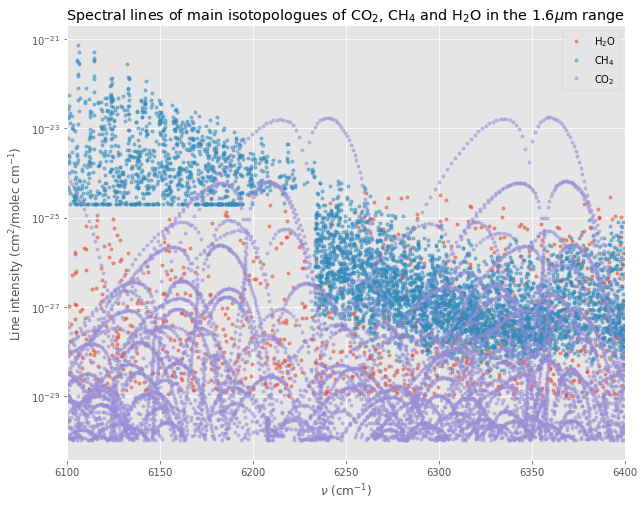

In [16]:
# and then plot them:
plt.semilogy(nu_H2O, sw_H2O, '.',label='H$_2$O', alpha=0.5)
plt.semilogy(nu_CH4, sw_CH4, '.',label='CH$_4$', alpha=0.5)
plt.semilogy(nu_CO2, sw_CO2, '.',label='CO$_2$', alpha=0.5)
plt.xlim((xmin,xmax))
plt.xlabel(r'$\nu$ (cm$^{-1}$)')
plt.ylabel('Line intensity (cm$^{2}$/molec cm$^{-1}$) ')
plt.legend(loc=0)
plt.title('Spectral lines of main isotopologues of CO$_2$, CH$_4$ and H$_2$O in the 1.6$\mu$m range')

This looks pretty messy as it includes a lot of very weak transitions, which may not matter after all. However, you can start seeing actual bands appearing with their P,Q and R branched (e.g. the methane 2$\nu_3$ band, an overtone of the $\nu_3$ band) centered at around 6000cm$^{-1}$. 

#### Computing line-shapes and cross sections using HAPI
Now we actually want to compute some line-shapes using HAPI, which provides options for Doppler, Lorentz, Voigt but also more advanced line-shapes. 

In [17]:
# Compute cross sections for CO2, CH4 and H2O at standard conditions (using Lorentz to save time for now):
nu_, cs_co2 = absorptionCoefficient_Lorentz(SourceTables='CO2_S', WavenumberRange=[xmin,xmax],Environment={'p':1.,'T':293},IntensityThreshold=1e-27)
nu_, cs_ch4 = absorptionCoefficient_Voigt(SourceTables='CH4_S',WavenumberRange=[xmin,xmax],Environment={'p':1.,'T':293},IntensityThreshold=1e-27)
nu_, cs_h2o = absorptionCoefficient_Lorentz(SourceTables='H2O_S',WavenumberRange=[xmin,xmax],Environment={'p':1.,'T':293},IntensityThreshold=1e-27)

(6100, 6400)

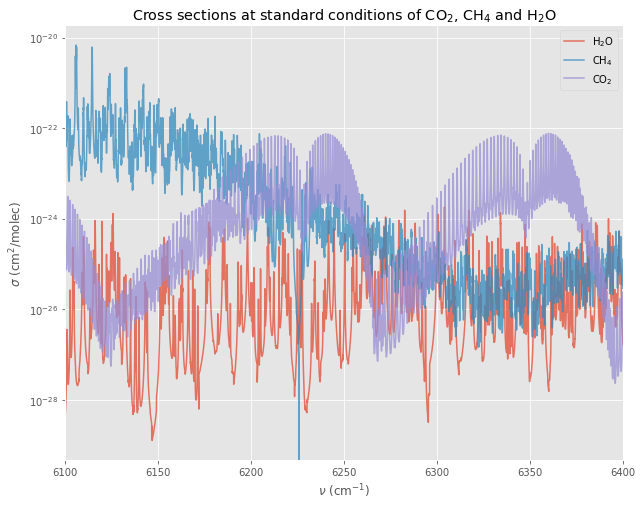

In [18]:
plt.semilogy(nu_, cs_h2o,label='H$_2$O', alpha=0.75)
plt.semilogy(nu_, cs_ch4,label='CH$_4$', alpha=0.75)
plt.semilogy(nu_, cs_co2,label='CO$_2$', alpha=0.75)
plt.legend(loc=0)
plt.xlabel(r'$\nu$ (cm$^{-1}$)')
plt.ylabel('$\sigma$ (cm$^{2}$/molec) ')
plt.title('Cross sections at standard conditions of CO$_2$, CH$_4$ and H$_2$O')
plt.xlim((xmin,xmax))
#print(nu_.shape)

#### Looping through all atmospheric layers!
Now, we want to compute all cross sections for the atmospheric profile obtained for Caltech from the model data. For this, we will actually use a Voigt line-shape now, i.e. a combination or Doppler anr pressure broadening.

In [19]:
# Create matrix of cross sections for each atmospheric layer (takes quite some time!!):
# This 
cs_matrix_co2 = np.zeros((len(nu_),NLEV))
cs_matrix_ch4 = np.zeros((len(nu_),NLEV))
cs_matrix_h2o = np.zeros((len(nu_),NLEV))
# Loop over each layer 
for i in range(NLEV):
    print(str(i)+'/'+str(NLEV), end='\r')
    p_ = p_full[i]/1013.
    T_ = T_local[i]
    nu_, cs_co2 = absorptionCoefficient_Voigt(SourceTables='CO2_S', WavenumberRange=[xmin,xmax],Environment={'p':p_,'T':T_},IntensityThreshold=1e-27)
    nu_, cs_ch4 = absorptionCoefficient_Voigt(SourceTables='CH4_S', WavenumberRange=[xmin,xmax],Environment={'p':p_,'T':T_},IntensityThreshold=1e-27)
    nu_, cs_h2o = absorptionCoefficient_Voigt(SourceTables='H2O_S', WavenumberRange=[xmin,xmax],Environment={'p':p_,'T':T_},IntensityThreshold=1e-27)
    cs_matrix_co2[:,i] = cs_co2
    cs_matrix_ch4[:,i] = cs_ch4
    cs_matrix_h2o[:,i] = cs_h2o

Text(0, 0.5, '$\\sigma$ (cm$^{2}$/molec) ')

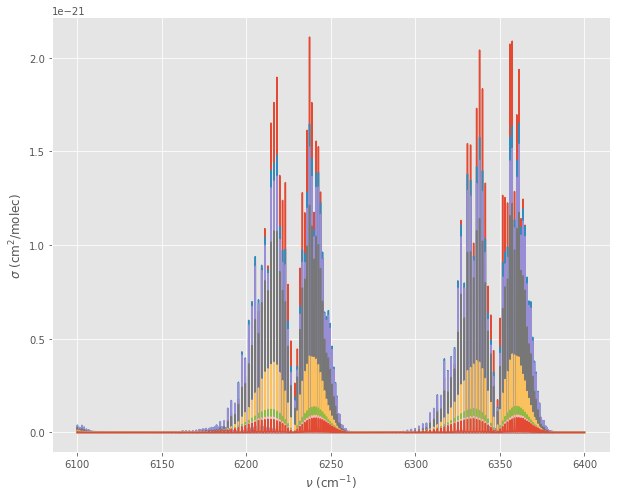

In [20]:
plt.plot(nu_,cs_matrix_co2[:,0::10])
#plt.xlim((6170,6270))
plt.xlabel(r'$\nu$ (cm$^{-1}$)')
plt.ylabel('$\sigma$ (cm$^{2}$/molec) ')

Text(0.5, 1.0, 'Zoom on a single CO$_2$ line at different layers (every 10th is plotted)')

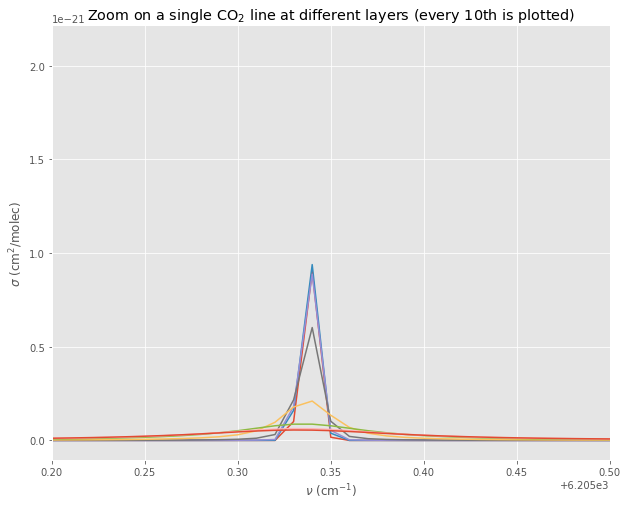

In [21]:
plt.plot(nu_,cs_matrix_co2[:,0::10])
plt.xlim((6205.2,6205.5))
plt.xlabel(r'$\nu$ (cm$^{-1}$)')
plt.ylabel('$\sigma$ (cm$^{2}$/molec) ')
plt.title('Zoom on a single CO$_2$ line at different layers (every 10th is plotted)')

In this figure you can already see that the spectral sampling interval of 0.01cm$^{-1}$ can be somewhat coarse for purely Doppler-broadenend lines higher up in the atmosphere.
_____

#### Generating a synthetic measurement using an up-looking geometry
Now we can start building our own forward model, using the layer-based optical properties and assuming a specific solar zenith angle and a direct light-path between the sun and the actual measurement on the ground, similar to TCCON.

Text(0, 0.5, 'Transmission')

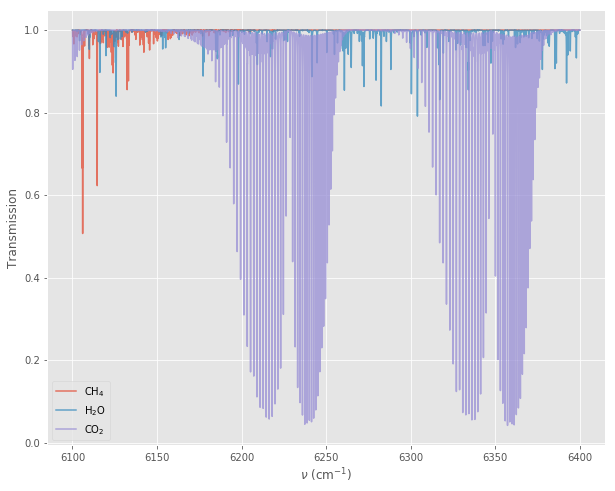

In [22]:
SZA = 45./180.*np.pi
# Single air mass factor (1 way path), ignores refraction and Earth's curvature here
AMF = 1/np.cos(SZA)

# Generate matrices of optical thickness per layer now for each gas: 
tau_co2 = cs_matrix_co2*VCD_dry*400.e-6
VCD_h2o = dz*rho_N_h2o
tau_h2o = cs_matrix_h2o*VCD_h2o
tau_ch4 = cs_matrix_ch4*VCD_dry*1.8e-6

plt.plot(nu_, np.exp(-AMF*np.sum(tau_ch4,1)), alpha=0.75, label='CH$_4$')
plt.plot(nu_, np.exp(-AMF*np.sum(tau_h2o,1)), alpha=0.75, label='H$_2$O')
plt.plot(nu_, np.exp(-AMF*np.sum(tau_co2,1)), alpha=0.75, label='CO$_2$')
#plt.xlim((5900,6300))
plt.legend(loc=0)
plt.xlabel(r'$\nu$ (cm$^{-1}$)')
plt.ylabel('Transmission')

### Writing a simple forward model
Now we can start writing a simple forward model that generates a synthetic measurement based on the SZA as well as the mixing ratio profiles. We can also use a baseline polynomial again to account for any broad-based changes as well as intensity changes, caused by spectrally flat extinction along the pathway due to aerosols for instance (instead of transmission)

In [24]:
# Import a Gaussian convolution
from scipy.ndimage.filters import gaussian_filter1d
# Import a 1D interpolation routine
from scipy.interpolate import interp1d

def TCCON_Style_T(vmr_h2o, vmr_co2, vmr_ch4, poly, SZA, FWHM, nu_in, nu_out):
    # Compute total optical thickness
    total_od = np.sum(cs_matrix_co2*VCD_dry*vmr_co2,1)+np.sum(cs_matrix_ch4*VCD_dry*vmr_ch4,1)+np.sum(cs_matrix_h2o*VCD_dry*vmr_h2o,1)
    # Compute Air Mass Factor given SZA
    AMF = 1./cos(SZA/180.*np.pi)
    # Compute transmission
    F = np.exp(-AMF*total_od)
    # Multiply with our baseline polynomial
    F = F*np.polyval(poly, nu_in-np.mean(nu_in))
    # Now apply the instrument function, here just a convolution with a Gaussian instrument function:
    co = 2.355
    res = nu_in[1]-nu_in[0]
    
    
    
    # Takes 1-sigma in number of pixels as 2nd argument for the Gaussian Width!
    F = gaussian_filter1d(F, FWHM/res/co)
    
    # Now interpolate to the new spectral grid of the spectrometer:
    #finter = interp1d(nu_in, F,kind='cubic')
    # Use linear just to save time:
    finter = interp1d(nu_in, F,kind='linear')
    
    return finter(nu_out)
    

____________
Let's try whether the simple forward model works!

In [25]:
# Generate CO2 and CH4 VMR vectors (basically our prior here)
vmr_co2 = np.ones((NLEV,))*400e-6 
vmr_ch4 = np.ones((NLEV,))*1.8e-6
# use a simple polynomial:
poly = [1e-7,-0.002,15]


Text(0, 0.5, 'Radiance (arbitrary units)')

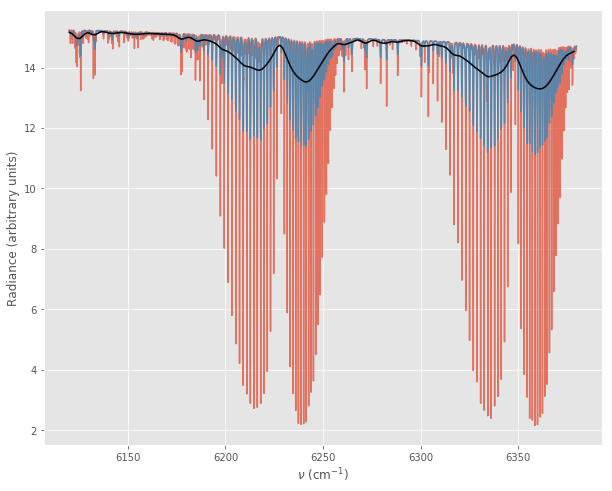

In [26]:
# Define a few different instruments with different spectral resolutions:
FWHM_1 = 0.02 # TCCON 
FWHM_2 = 0.4  # OCO-2 
FWHM_3 = 4.0  # SCIAMACHY

# Assume a spectral sampling of FWHM/3
nu_out1 = np.arange(6120,6380,FWHM_1/3.)
nu_out2 = np.arange(6120,6380,FWHM_2/3.)
nu_out3 = np.arange(6120,6380,FWHM_3/3.)

# Actually run the forward model:
T1 = TCCON_Style_T(vmr_h2o, vmr_co2, vmr_ch4, poly, 30., FWHM_1, nu_, nu_out1)
T2 = TCCON_Style_T(vmr_h2o, vmr_co2, vmr_ch4, poly, 30., FWHM_2, nu_, nu_out2)
T3 = TCCON_Style_T(vmr_h2o, vmr_co2, vmr_ch4, poly, 30., FWHM_3, nu_, nu_out3)
plt.plot(nu_out1, T1,label='TCCON-like measurement', alpha=0.75)
plt.plot(nu_out2, T2,label='OCO-2-like measurement', alpha=0.75)
plt.plot(nu_out3, T3,'-k',label='SCIAMACHY-like measurement')
plt.xlabel(r'$\nu$ (cm$^{-1}$)')
plt.ylabel('Radiance (arbitrary units)')

_____
The simple function above is an almost complete example of a forward model that can simulate an actual measurement. We can also write it in a way that we just need to provide a full state-vector $x$, which can include all trace gas VMRs as well as the polynomial and also a parameterization of the spectral sampling. SZA and FWHM would be external parameters that need to be provided but not fitted (but might have uncertainty themselves). 

There is one other thing that we forgot, namely Fraunhofer lines!
![title](img/Fraunhofer.jpg)

Similar to the atmospheric line transitions, there are databaases for solar absorption features. We now want to read  solar transmission spectrum (disk integrated vs. disk centered). A generated spectrum using a solar line-list (not a low resolution measured spectrum) can be downloaded at http://mark4sun.jpl.nasa.gov/toon/solar/solar_spectrum.html.

The solar transmission spectrum is basically calculated from a tabulated line-list (strength and width) compiled by Geoff Toon from JPL. These absorption features are caused by absorptions of trace elements in the solar photosphere.

In [28]:
# Read in disk-centered solar spectrum:
sun = np.loadtxt('files/solar_merged_20160127_600_26316_000.out')



Text(0.5, 1.0, 'Disk-centered solar transmission spectrum')

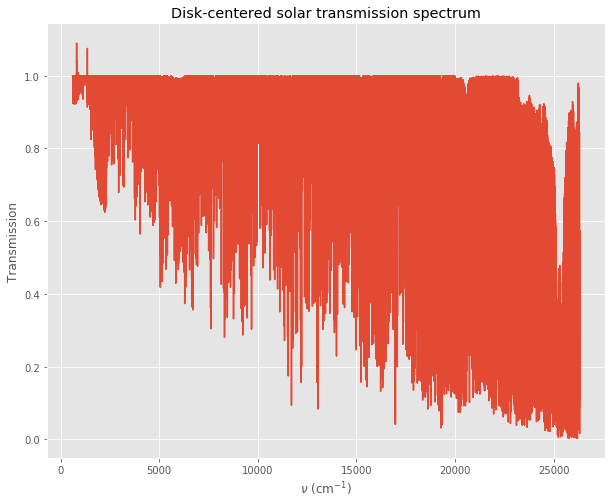

In [29]:
# plot 
plt.plot(sun[:,0], sun[:,1])
plt.xlabel(r'$\nu$ (cm$^{-1}$)')
plt.ylabel('Transmission')
plt.title('Disk-centered solar transmission spectrum')

Text(0.5, 1.0, 'Disk-centered solar transmission spectrum')

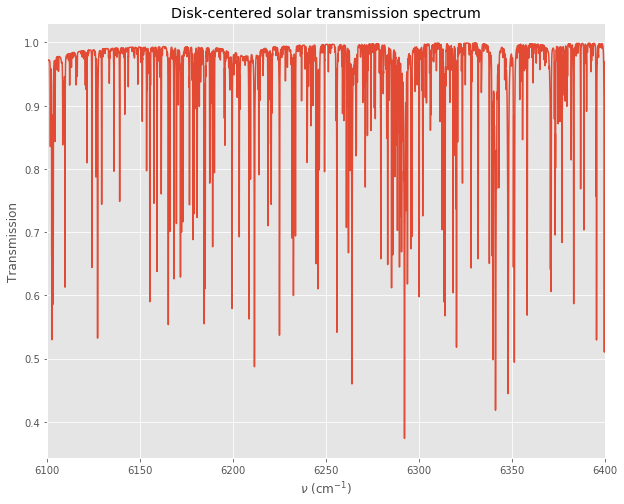

In [30]:
# Let us just use it at the nu_ wavenumber grid as before
f_solar = interp1d(sun[:,0], sun[:,1])
Tsolar = f_solar(nu_)
plt.plot(nu_, Tsolar)
plt.xlabel(r'$\nu$ (cm$^{-1}$)')
plt.ylabel('Transmission')
plt.xlim((xmin,xmax))
plt.title('Disk-centered solar transmission spectrum')

Now we can incorporate the solar transmission spectrum into the forward model
____

In [31]:
def TCCON_Style_T_solar(vmr_h2o, vmr_co2, vmr_ch4, poly, SZA, FWHM, nu_in, nu_out,Tsolar):
    # Compute total optical thickness
    total_od = np.sum(cs_matrix_co2*VCD_dry*vmr_co2,1)+np.sum(cs_matrix_ch4*VCD_dry*vmr_ch4,1)+np.sum(cs_matrix_h2o*VCD_dry*vmr_h2o,1)
    # Compute Air Mass Factor given SZA
    AMF = 1./cos(SZA/180.*np.pi)
    # Compute transmission
    F = Tsolar*np.exp(-AMF*total_od)
    # Multiply with our baseline polynomial
    F = F*np.polyval(poly, nu_in-np.mean(nu_in))
    # Now apply the instrument function, here just a convolution with a Gaussian instrument function:
    co = 2.355
    res = nu_in[1]-nu_in[0]
    
    # Takes 1-sigma in number of pixels as 2nd argument for the Gaussian Width!
    F = gaussian_filter1d(F, FWHM/res/co)
    
    # Now interpolate to the new spectral grid of the spectrometer:
    #finter = interp1d(nu_in, F,kind='cubic')
    # Use linear just to save time:
    finter = interp1d(nu_in, F,kind='linear')
    
    return finter(nu_out)

Text(0, 0.5, 'Radiance (arbitrary units)')

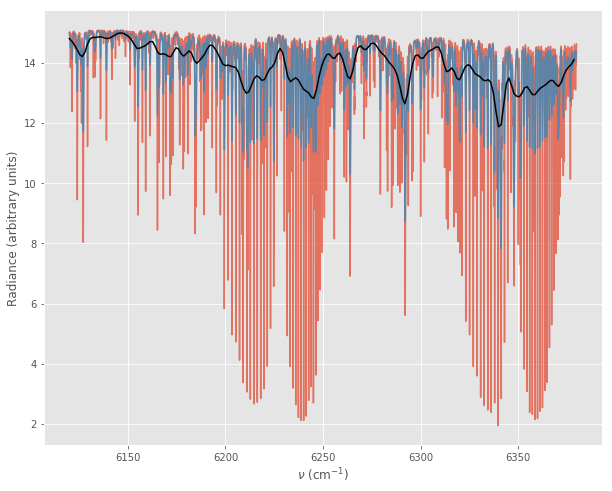

In [32]:
# Actually run the forward model:
T1 = TCCON_Style_T_solar(vmr_h2o, vmr_co2, vmr_ch4, poly, 30., FWHM_1, nu_, nu_out1,Tsolar)
T2 = TCCON_Style_T_solar(vmr_h2o, vmr_co2, vmr_ch4, poly, 30., FWHM_2, nu_, nu_out2,Tsolar)
T3 = TCCON_Style_T_solar(vmr_h2o, vmr_co2, vmr_ch4, poly, 30., FWHM_3, nu_, nu_out3,Tsolar)
plt.plot(nu_out1, T1,label='TCCON-like measurement', alpha=0.75)
plt.plot(nu_out2, T2,label='OCO-2-like measurement', alpha=0.75)
plt.plot(nu_out3, T3,'-k',label='SCIAMACHY-like measurement')
plt.xlabel(r'$\nu$ (cm$^{-1}$)')
plt.ylabel('Radiance (arbitrary units)')

_________
This notebook is pretty big already, so let's stop here and move on to another one for actually performing fits. 
We went through great pain (and time) already to compute the profiles as well as cross sections though, so let's save them. A very convenient way of doing this is to use standardized binary formats such as HDF (a version fully supported by all programming languages). Below, I will be using the h5py package to do so:


In [34]:
import h5py as h5
# Open up a file (will be generate if non-existent)
f = h5.File('files/crossSections_SCO2Band.h5')
# Save the most important variables we would like to keep:
f['CrossSections/cs_matrix_co2']=cs_matrix_co2
f['CrossSections/cs_matrix_ch4']=cs_matrix_ch4
f['CrossSections/cs_matrix_h2o']=cs_matrix_h2o
f['Profiles/VCD_dry']=VCD_dry
f['Profiles/vmr_h2o']=vmr_h2o
f['wavenumberGrid']=nu_
f['Tsolar']=Tsolar 
f['Profiles/p']=p_full
f.close()


Beware: The code above can only be executed once (i.e. if the variables in the file doesn't exist yet)

In [39]:
import h5py as h5
# Open up a file (will be generate if non-existent)
f = h5.File('Data/crossSections.h5')
# Save the most important variables we would like to keep:
cs_matrix_co2 = f['CrossSections/cs_matrix_co2'][:]
cs_matrix_ch4 = f['CrossSections/cs_matrix_ch4'][:]
cs_matrix_h2o = f['CrossSections/cs_matrix_h2o'][:]
VCD_dry = f['Profiles/VCD_dry'][:]
vmr_h2o = f['Profiles/vmr_h2o'][:]
nu_ = f['wavenumberGrid'][:]
#f['Tsolar']=Tsolar 
p_full = f['Profiles/p'][:]
f.close()